In [1]:
#import basic libraries
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
#load dataset
dataset = pd.read_csv('voice.csv')
dataset.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


This kernel will use an artificial neural net to classify voices by gender. The neural net will have two hidden layers, will use a rectifier activation function for each node in the hidden layers, and use a logistic activation function to recieve probabilities of each class in the output layer and will use stochastic gradient descent to minimize the objective function (cross entropy). We begin by reading the dataset and do some elementary data exploration.

In [3]:
#let's Describe the dataset
dataset.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [4]:
#Find the correlation between attributes
dataset.corr()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,0.687715,1.000000,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,-0.529150,-0.739039,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,0.677433,0.925445,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,0.591277,0.911416,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,0.486857,0.740997,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475
IQR,-0.627605,0.874660,-0.477352,-0.874189,0.009636,1.000000,0.249497,0.316185,0.640813,0.663601,-0.403764,-0.627605,-0.534462,-0.222680,-0.069588,-0.333362,-0.357037,-0.337877,-0.331563,0.041252
skew,-0.322327,0.314597,-0.257407,-0.319475,-0.206339,0.249497,1.000000,0.977020,-0.195459,0.079694,-0.434859,-0.322327,-0.167668,-0.216954,-0.080861,-0.336848,-0.061608,-0.305651,-0.304640,-0.169325
kurt,-0.316036,0.346241,-0.243382,-0.350182,-0.148881,0.316185,0.977020,1.000000,-0.127644,0.109884,-0.406722,-0.316036,-0.194560,-0.203201,-0.045667,-0.303234,-0.103313,-0.274500,-0.272729,-0.205539
sp.ent,-0.601203,0.716620,-0.502005,-0.648126,-0.174905,0.640813,-0.195459,-0.127644,1.000000,0.866411,-0.325298,-0.601203,-0.513194,-0.305826,-0.120738,-0.293562,-0.294869,-0.324253,-0.319054,0.198074
sfm,-0.784332,0.838086,-0.661690,-0.766875,-0.378198,0.663601,0.079694,0.109884,0.866411,1.000000,-0.485913,-0.784332,-0.421066,-0.362100,-0.192369,-0.428442,-0.289593,-0.436649,-0.431580,0.211477


In [5]:
#Split the dataset as per independent and dependent variable
num_columns = dataset.shape[1]
x = dataset.iloc[:,:20].values
y = dataset.iloc[:,20].values

The one non numeric category (labels) needs to be encoded using dummy variables,when we assign integer values to gender (binary variable in this case), it becomes a dummy variable.

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
gender_labels = LabelEncoder()
y = gender_labels.fit_transform(y)
# lets see which is 0 and which is 1
print(list(gender_labels.inverse_transform([0,1])))

['female', 'male']


/home/kishor/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Generate testing and training dataset

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

These variables are between 0 and 1, but we normalize them so that they have comparable weightings.

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Creating an artificial neural network using keras, by building the layers two hidden layers and an output layer, then train the neural network on the training set.

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units = 11, activation = 'relu',kernel_initializer = 'uniform', input_shape = (20,)))
classifier.add(Dense(units = 11, activation = 'relu', kernel_initializer = 'uniform'))
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform', input_shape = (20,)))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(x_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
2534/2534 [==============================] - 1s 357us/step - loss: 0.5129 - acc: 0.8106
Epoch 2/100
2534/2534 [==============================] - 0s 105us/step - loss: 0.1296 - acc: 0.9672
Epoch 3/100
2534/2534 [==============================] - 0s 104us/step - loss: 0.0899 - acc: 0.9736
Epoch 4/100
2534/2534 [==============================] - 0s 105us/step - loss: 0.0822 - acc: 0.9740
Epoch 5/100
2534/2534 [==============================] - 0s 103us/step - loss: 0.0782 - acc: 0.9759
Epoch 6/100
2534/2534 [==============================] - 0s 103us/step - loss: 0.0772 - acc: 0.9775
Epoch 7/100
2534/2534 [==============================] - 0s 107us/step - loss: 0.0743 - acc: 0.9787
Epoch 8/100
2534/2534 [==============================] - 0s 108us/step - loss: 0.0728 - acc: 0.9779
Epoch 9/100
2534/2534 [==============================] - 0s 110us/step - loss: 0.0718 - acc: 0.9783
Epoch 10/100
2534/2534 [==============================] - 0s 106us/step - loss: 0.0715 - acc: 0.9783

2534/2534 [==============================] - 0s 136us/step - loss: 0.0405 - acc: 0.9878
Epoch 83/100
2534/2534 [==============================] - 0s 110us/step - loss: 0.0401 - acc: 0.9882
Epoch 84/100
2534/2534 [==============================] - 0s 105us/step - loss: 0.0392 - acc: 0.9886
Epoch 85/100
2534/2534 [==============================] - 0s 109us/step - loss: 0.0371 - acc: 0.9901
Epoch 86/100
2534/2534 [==============================] - 0s 108us/step - loss: 0.0399 - acc: 0.9878
Epoch 87/100
2534/2534 [==============================] - 0s 110us/step - loss: 0.0404 - acc: 0.9890
Epoch 88/100
2534/2534 [==============================] - 0s 105us/step - loss: 0.0377 - acc: 0.9901
Epoch 89/100
2534/2534 [==============================] - 0s 105us/step - loss: 0.0388 - acc: 0.9874
Epoch 90/100
2534/2534 [==============================] - 0s 106us/step - loss: 0.0389 - acc: 0.9878
Epoch 91/100
2534/2534 [==============================] - 0s 108us/step - loss: 0.0362 - acc: 0.9886
Epo

The neural network is now built and trained, the weights are set, now we can evaluate the generalization performance of the neural network on the testing dataset. We then use the threshold of 0.50 to convert output probilities from the sigmoid activation function into binary predictions for gender.

In [13]:
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5 )

Evaluate the performance of the neural network using a confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[296   5]
 [ 10 323]]


A more fashionable plot, recall that 0 is female and 1 is male

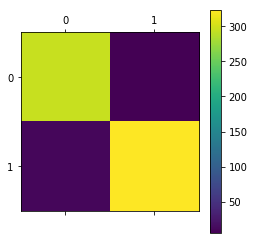

In [18]:
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.colorbar()

Results on the testing dataset are fantastic the confusion matrix shows that the neural net predicts gender on the testing dataset with 98.3% accuracy.